# Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus


In [43]:
import requests
import tarfile
import urllib
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt
import re
import gzip

## 1. Loading data

We first extract all files from the [MoviesSummaries dataset](http://www.cs.cmu.edu/~ark/personas/). 

In [13]:
if not os.path.exists('Data/MovieSummaries'):
    filename = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    my_tar = tarfile.open(fileobj=urllib.request.urlopen(filename), mode="r:gz") 
    my_tar.extractall('./Data') # specify which folder to extract to
    my_tar.close()

## 2. Pre-processing data

### 1. Plot summaries

`plot_summaries.txt [29 M]`: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [14]:
plot_path = 'Data/MovieSummaries/plot_summaries.txt'
plot_cols = ['Wikipedia ID', 'Summary']
plot_df = pd.read_csv(plot_path, sep='\t', header=None, names=plot_cols, index_col=0)
plot_df

,Summary
Wikipedia ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...


### 2. Movie metadata

`movie.metadata.tsv.gz [3.4 M]`: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


In [82]:
strip_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [83]:
movie_path = 'Data/MovieSummaries/movie.metadata.tsv'
movie_cols = ['Wikipedia ID', 'Freebase ID', 'Name', 'Release date', 
              'Box office revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
movie_df = pd.read_csv(movie_path, sep='\t', header=None, names=movie_cols, index_col=0, dtype = {'Freebase ID': str})
movie_df['Languages'] = movie_df['Languages'].apply(strip_encoding)
movie_df['Countries'] = movie_df['Countries'].apply(strip_encoding)
movie_df['Genres'] = movie_df['Genres'].apply(strip_encoding)
movie_df

,Freebase ID,Name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
Wikipedia ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama]
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English],[United States of America],"[Satire, Comedy]"


### 3. Character metadata

`character.metadata.tsv.gz [14 M]`: Metadata for 450,669 characters aligned to the movies above, extracted from the November 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


In [84]:
char_path = 'Data/MovieSummaries/character.metadata.tsv'
char_cols = ['Wikipedia ID', 'Freebase ID', 'Release date', 'Character name', 'Date of birth', 
             'Gender', 'Height', 'Ethnicity', 'Actor name', 'Actor age at release', 
             'Freebase character/map ID', 'Freebase character ID', 'Freebase actor ID']
char_df = pd.read_csv(char_path, sep='\t', header=None, names=char_cols, index_col=0)
char_df

,Freebase ID,Release date,Character name,Date of birth,Gender,Height,Ethnicity,Actor name,Actor age at release,Freebase character/map ID,Freebase character ID,Freebase actor ID
Wikipedia ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...
913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44


## General analysis

### -Analysis romantic genres

In [85]:
##One notices that there are several types of romantic movies: romantic comedy, romance film, romantic drama
romance_genres = ['Romantic comedy', 'Romance Film', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
romance_movies = movie_df[movie_df['Genres'].apply(lambda x: any(y in romance_genres for y in x) if type(x) == list else False)]

In [86]:
#Organize by category
romantic_comedy = romance_movies[movie_df['Genres'].apply(lambda x: any(y in romance_genres[0] for y in x) if type(x) == list else False)]
romantic_film = romance_movies[movie_df['Genres'].apply(lambda x: any(y in romance_genres[1] for y in x) if type(x) == list else False)]
romantic_drama = romance_movies[movie_df['Genres'].apply(lambda x: any(y in romance_genres[2] for y in x) if type(x) == list else False)]
romantic_fantasy = romance_movies[movie_df['Genres'].apply(lambda x: any(y in romance_genres[3] for y in x) if type(x) == list else False)]
romantic_thriller = romance_movies[movie_df['Genres'].apply(lambda x: any(y in romance_genres[4] for y in x) if type(x) == list else False)]

print('Roman' , romance_movies.shape[0])
print('Romantic comedies: ', romantic_comedy.shape[0], '\nRomantic films: ', romantic_film.shape[0], '\nRomantic drama: ', romantic_drama.shape[0], '\nRomantic fantasy: ', romantic_fantasy.shape[0], '\nRomantic thriller: ', romantic_thriller.shape[0])
print('Total number of films: ', movie_df.shape[0])

Roman 11131
Romantic comedies:  2680 
Romantic films:  10234 
Romantic drama:  3372 
Romantic fantasy:  72 
Romantic thriller:  1
Total number of films:  81741


/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_47608/4191339270.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  romantic_comedy = romance_movies[movie_df['Genres'].apply(lambda x: any(y in romance_genres[0] for y in x) if type(x) == list else False)]
/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_47608/4191339270.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  romantic_film = romance_movies[movie_df['Genres'].apply(lambda x: any(y in romance_genres[1] for y in x) if type(x) == list else False)]
/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_47608/4191339270.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  romantic_drama = romance_movies[movie_df['Genres'].apply(lambda x: any(y in romance_genres[2] for y in x) if type(x) == list else False)]
/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_47608/4191339270.py:5: UserWarning: Boolean Ser

### Romantic movies runtime

In [87]:
##Should correct outliers
#combined_runtime = pd.DataFrame({'Romantic comedy': romantic_comedy['Runtime'], 'Romance Film': romantic_film['Runtime'], 'Romantic drama': romantic_drama['Runtime'], 'Romantic fantasy': romantic_fantasy['Runtime']})
#sns.boxplot(combined_runtime)

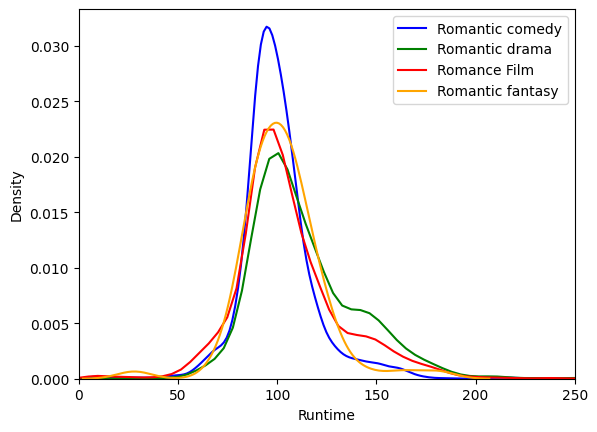

In [88]:
ax = sns.kdeplot(romantic_comedy['Runtime'], color='blue')
ax = sns.kdeplot(romantic_drama['Runtime'], color='green')
ax = sns.kdeplot(romantic_film['Runtime'], color='red')
ax = sns.kdeplot(romantic_fantasy['Runtime'], color='orange')
ax.set_xlim(0,250)
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy'])


### Romantic movies box office revenue

In [89]:
#Does not give a good view
#combined_box_office = pd.DataFrame({'Romantic comedy': romantic_comedy['Box office revenue'], 'Romance Film': romantic_film['Box office revenue'], 'Romantic drama': romantic_drama['Box office revenue'], 'Romantic fantasy': romantic_fantasy['Box office revenue']})
#sns.boxplot(combined_box_office)

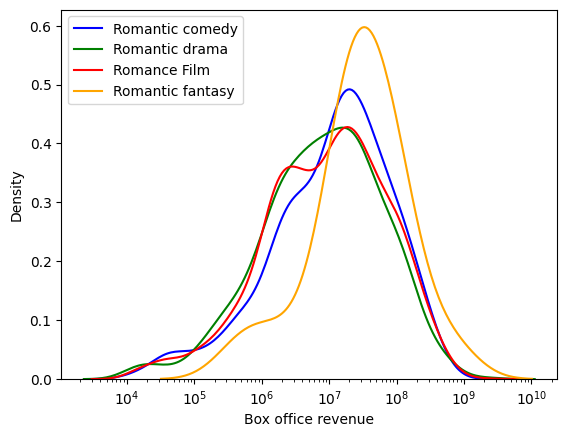

In [90]:
ax = sns.kdeplot(romantic_comedy['Box office revenue'], log_scale=True, color='blue')
ax = sns.kdeplot(romantic_drama['Box office revenue'], log_scale=True, color='green')
ax = sns.kdeplot(romantic_film['Box office revenue'], log_scale=True, color='red')
ax = sns.kdeplot(romantic_fantasy['Box office revenue'], log_scale=True, color='orange')
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy'])


### Romantic movies countries

In [93]:
romantic_comedy

,Freebase ID,Name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
Wikipedia ID,,,,,,,,
6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,..."
21926710,/m/05p45cv,White on Rice,2009,NaN,82.0,NaN,[United States of America],"[Romantic comedy, Romance Film, Comedy, Indie]"
26067101,/m/0b6c_nw,Siam Sunset,1999,NaN,91.0,NaN,"[Australia, New Zealand]","[Romantic comedy, Romance Film, Comedy, World ..."
12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,[English],[United States of America],"[Romantic comedy, Romance Film, Comedy]"
7028314,/m/0h10pz,The Little Hut,1957-05-03,3600000.0,90.0,[English],[United States of America],"[Romantic comedy, Romance Film, Comedy]"
...,...,...,...,...,...,...,...,...
1001692,/m/03y72s,The Divorce of Lady X,1938,NaN,92.0,[English],[United Kingdom],"[Romantic comedy, Romance Film, Comedy of Erro..."
25655938,/m/09v7p4g,I Was a Mail Order Bride,1982-12-14,NaN,92.0,[English],[United States of America],[Romantic comedy]
11823946,/m/02rtqvb,Twelfth Night: Or What You Will,1996-10-25,588621.0,134.0,[English],"[United States of America, Ireland, United Kin...","[Romantic comedy, Romance Film, Drama, Comedy,..."


In [96]:
get_countries = lambda x: len(x) if type(x) == list else np.nan
romantic_comedy['number_countries'] = romantic_comedy['Countries'].apply(get_countries)
romantic_fantasy['number_countries'] = romantic_fantasy['Countries'].apply(get_countries)
romantic_film['number_countries'] = romantic_film['Countries'].apply(get_countries)
romantic_drama['number_countries'] = romantic_drama['Countries'].apply(get_countries)

combined_numb_countries = pd.DataFrame({
    'Romantic comedy': romantic_comedy['number_countries'], 
    'Romance Film': romantic_film['number_countries'], 
    'Romantic drama': romantic_drama['number_countries'], 
    'Romantic fantasy': romantic_fantasy['number_countries']})

print('Percentage romantic comedy movie countries > 1: ', round(romantic_comedy[romantic_comedy['number_countries']> 1].shape[0]/romantic_comedy.shape[0], 2), '%')
print('Other countries can be added in code...')

Percentage romantic comedy movie countries > 1:  0.14 %
Other countries can be added in code...


/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_47608/2615585845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  romantic_comedy['number_countries'] = romantic_comedy['Countries'].apply(get_countries)
/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_47608/2615585845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  romantic_fantasy['number_countries'] = romantic_fantasy['Countries'].apply(get_countries)
/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_47608/2615585845.py

### Movie languages

In [99]:
#Get languages whole movie set
movies_language = movie_df[movie_df['Languages'].notnull()]
languages=movies_language['Languages'].sum()
values, counts = np.unique(languages, return_counts=True)
print('5 most common languages in movies are: ')
print(values[counts.argsort()[-5:][::-1]])

#Get languages romantic movies overall
romance_movies_lang = romance_movies[romance_movies['Languages'].notnull()]
languages_romance = romance_movies_lang.Languages.sum()
values, counts = np.unique(languages_romance, return_counts=True)
print('5 most common languages in romantic movies: ')
print(values[counts.argsort()[-5:][::-1]])


rom_com_known = romantic_comedy[romantic_comedy['Languages'].notnull()]
languages_romcom = rom_com_known.Languages.sum()
values, counts = np.unique(languages_romcom, return_counts=True)
print('\n5 most common languages in romantic comedies: ')
print(values[counts.argsort()[-5:][::-1]])

5 most common languages in movies are: 
['English' 'Hindi' 'Spanish' 'French' 'Silent film']
5 most common languages in romantic movies: 
['English' 'Hindi' 'French' 'Tamil' 'Spanish']

5 most common languages in romantic comedies: 
['English' 'French' 'Hindi' 'Spanish' 'Italian']


### 4. CoreNLP Plot Summaries

`corenlp_plot_summaries.tar.gz [628 M, separate download]`: The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

Note: Extraction takes 15min42s, while conversion takes 33s. 

In [58]:
# Extract all coreNLP files to Data/CoreNLP
if not os.path.exists('Data/CoreNLP'):
    coreNLPfilename = 'http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar'
    my_tar = tarfile.open(fileobj=urllib.request.urlopen(coreNLPfilename), mode="r|") 
    my_tar.extractall(path='./Data/CoreNLP') # specify which folder to extract to
    my_tar.close()

In [59]:
# Convert every file in directory Data/CoreNLP to xml format
raw_dir = 'Data/CoreNLP/corenlp_plot_summaries'
extracted_dir = 'Data/CoreNLP/corenlp_plot_summaries_xml'
os.mkdir(extracted_dir)
for filename in os.listdir(raw_dir):
    f = os.path.join(raw_dir, filename) 
    if os.path.isfile(f):
        # Open and store file as xml 
        with gzip.open(f, 'rb') as f_in:
            gz_file = os.path.join(extracted_dir, filename)
            with open(gz_file[:-3], 'wb') as f_out:
                f_out.write(f_in.read())


In [63]:
#Use file I already extracted on my computer to run some tests
import xml.etree.ElementTree as ET
tree = ET.parse('Data/CoreNLP/corenlp_plot_summaries_xml/3217.xml')
root = tree.getroot()

#NER tag = person can give us the characters mention in the plot summary. 

print(len(root.findall('.//*governor'))) #use parse or basic-dependencies to have more info 
#print(root.findall('.//*governor').text())
for l in root.findall('.//*NER'): 
  if len(l.text) > 1:
    print(l.text)


1220
ORGANIZATION
ORGANIZATION
DATE
PERSON
PERSON
ORGANIZATION
ORGANIZATION
PERSON
PERSON
MISC
PERSON
MISC
MISC
PERSON
PERSON
NUMBER
ORGANIZATION
MISC
MISC
MISC
MISC
PERSON
PERSON
LOCATION
NUMBER
ORGANIZATION
LOCATION
ORGANIZATION
ORGANIZATION
NUMBER
NUMBER
NUMBER
PERSON
MISC
ORGANIZATION
ORGANIZATION
ORGANIZATION
MISC
PERSON
PERSON
ORGANIZATION
DATE
ORGANIZATION
ORGANIZATION
NUMBER
ORGANIZATION
ORGANIZATION
PERSON
ORGANIZATION
ORGANIZATION
ORGANIZATION
LOCATION
ORGANIZATION
ORGANIZATION


### 5. TV Tropes Clusters

We reformat the file `tvtropes.clusters.txt` so it is easier to use.

In [ ]:
path = 'Data/MovieSummaries/'
cluster_path = path+'tvtropes.clusters.format.txt'
cluster_cols = ['Cluster', 'Character name', 'Movie', 'Freebase character/map ID', 'Actor']
cluster_df = pd.read_csv(cluster_path, sep=',', header=None, names=cluster_cols, dtype = {'Freebase ID': str})
cluster_df

### 6. Join cluster and movies

 We now join the TV tropes clusters with movie.metadata so we are able to access movie genre and filter on romance. 

In [ ]:
cluster_char = cluster_df.merge(char_df, on='Freebase character/map ID')
cluster_char_movie = cluster_char.merge(movie_df, on='Freebase ID')
romance_cluster = cluster_char_movie[cluster_char_movie['Genres'].apply(lambda x: 'Roman' in x)]
romance_cluster.groupby(romance_cluster['Cluster']).size().sort_values(ascending=False)